In [1]:
# Inspired from https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue/notebook
import gc
import re
import json
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize
from scipy.stats import norm, probplot

In [34]:
IN_TRAIN = 'in/train-flat.csv'
IN_TEST = 'in/test-flat.csv'

OUT_TRAIN = 'in/train-pruned.csv'
OUT_TEST = 'in/test-pruned.csv'

In [3]:
%%time
train_df = pd.read_csv(IN_TRAIN, dtype={'fullVisitorId': 'str'}, low_memory=False)

Wall time: 14.4 s


In [4]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [5]:
%%time
test_df = pd.read_csv(IN_TEST, dtype={'fullVisitorId': 'str'}, low_memory=False)

Wall time: 12.7 s


In [6]:
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


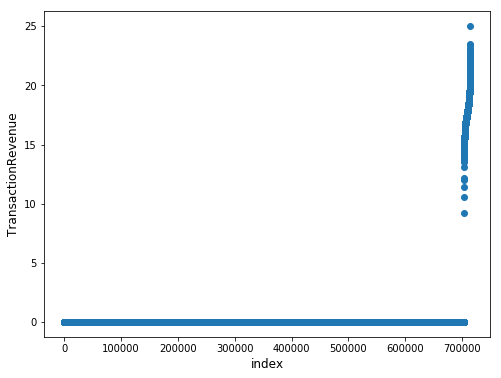

In [7]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [8]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


In [32]:
# remove cols which are not available in demo dataset
# TODO
# cols_not_available_in_demo_dataset = 
def remove_not_av_cols(df):
    not_av_series = df.loc[0] == 'not available in demo dataset'
    not_av_cols = not_av_series[not_av_series == True].keys()
    return df.drop(not_av_cols, axis=1)

train_df_pruned = remove_not_av_cols(train_df)
train_df_pruned.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,desktop,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,desktop,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,desktop,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,desktop,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,mobile,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [33]:
test_df_pruned = remove_not_av_cols(test_df)
test_df_pruned.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,mobile,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [35]:
%%time
train_df_pruned.to_csv(OUT_TRAIN, index=False)
test_df_pruned.to_csv(OUT_TEST, index=False)

Wall time: 28.6 s
